In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, ttest_ind


In [3]:
df = pd.read_csv("QVI_data.csv")
df.head(5)


,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,NATURAL,YOUNG SINGLES/COUPLES,Premium
1,1002,2018-09-16,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7,150,RRD,YOUNG SINGLES/COUPLES,Mainstream
2,1003,2019-03-07,1,3,52,Grain Waves Sour Cream&Chives 210G,1,3.6,210,GRNWVES,YOUNG FAMILIES,Budget
3,1003,2019-03-08,1,4,106,Natural ChipCo Hony Soy Chckn175g,1,3.0,175,NATURAL,YOUNG FAMILIES,Budget
4,1004,2018-11-02,1,5,96,WW Original Stacked Chips 160g,1,1.9,160,WOOLWORTHS,OLDER SINGLES/COUPLES,Mainstream


In [4]:
df['DATE'] = pd.to_datetime(df['DATE'])
df['MONTH'] = df['DATE'].dt.to_period('M')


In [5]:
monthly_metrics = df.groupby(['STORE_NBR', 'MONTH']).agg(
    total_sales=('TOT_SALES', 'sum'),
    customers=('LYLTY_CARD_NBR', 'nunique'),
    transactions=('TXN_ID', 'nunique')
).reset_index()

monthly_metrics['txn_per_customer'] = (
    monthly_metrics['transactions'] / monthly_metrics['customers']
)

monthly_metrics.head()


,STORE_NBR,MONTH,total_sales,customers,transactions,txn_per_customer
0,1,2018-07,206.9,49,52,1.061224
1,1,2018-08,176.1,42,43,1.023810
2,1,2018-09,278.8,59,62,1.050847
3,1,2018-10,188.1,44,45,1.022727
4,1,2018-11,192.6,46,47,1.021739


In [6]:
trial_stores = [77, 86, 88]
trial_start = pd.Period('2019-02', freq='M')

pre_trial = monthly_metrics[monthly_metrics['MONTH'] < trial_start]
trial_period = monthly_metrics[monthly_metrics['MONTH'] >= trial_start]


In [7]:
def select_control_store(trial_store, metric='total_sales'):
    trial_data = pre_trial[pre_trial['STORE_NBR'] == trial_store][metric]

    scores = []

    for store in pre_trial['STORE_NBR'].unique():
        if store in trial_stores:
            continue

        control_data = pre_trial[pre_trial['STORE_NBR'] == store][metric]

        if len(trial_data) == len(control_data):
            corr, _ = pearsonr(trial_data, control_data)
            distance = np.mean(np.abs(trial_data.values - control_data.values))

            scores.append({
                'store': store,
                'correlation': corr,
                'distance': distance
            })

    score_df = pd.DataFrame(scores)

    # Normalise distance
    score_df['distance_norm'] = 1 - (
        (score_df['distance'] - score_df['distance'].min()) /
        (score_df['distance'].max() - score_df['distance'].min())
    )

    # Final score
    score_df['final_score'] = (
        0.5 * score_df['correlation'] +
        0.5 * score_df['distance_norm']
    )

    return score_df.sort_values('final_score', ascending=False).iloc[0]['store']


In [8]:
control_stores = {}

for store in trial_stores:
    control = select_control_store(store)
    control_stores[store] = control
    print(f"Trial Store {store} → Control Store {control}")


Trial Store 77 → Control Store 233.0
Trial Store 86 → Control Store 155.0
Trial Store 88 → Control Store 125.0


In [9]:
def plot_pre_trial(trial, control, metric):
    trial_data = pre_trial[pre_trial['STORE_NBR'] == trial]
    control_data = pre_trial[pre_trial['STORE_NBR'] == control]

    plt.figure(figsize=(10,5))
    plt.plot(trial_data['MONTH'].astype(str), trial_data[metric], label='Trial')
    plt.plot(control_data['MONTH'].astype(str), control_data[metric], label='Control')
    plt.xticks(rotation=45)
    plt.title(f'Pre-Trial {metric} Comparison: Store {trial}')
    plt.legend()
    plt.show()


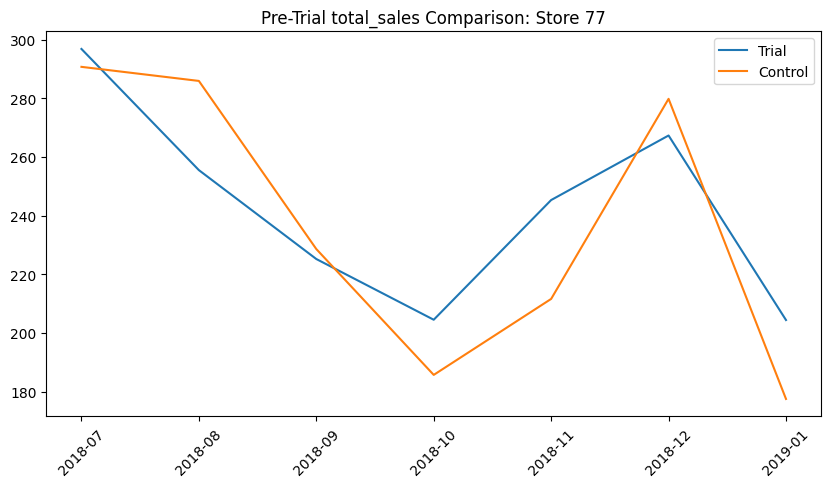

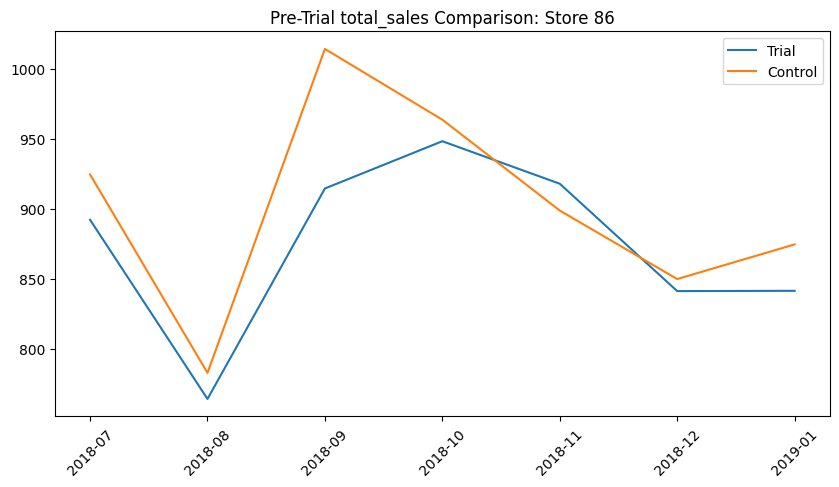

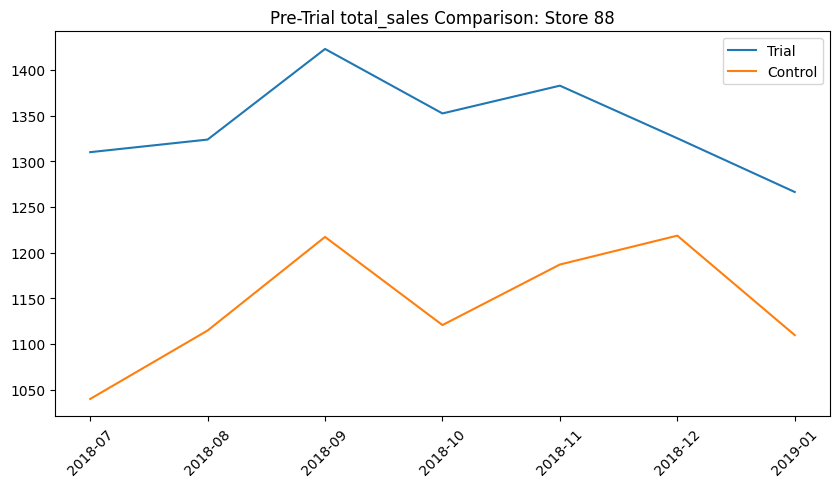

In [10]:
for store in trial_stores:
    plot_pre_trial(store, control_stores[store], 'total_sales')


In [11]:
def compare_trial(trial, control, metric):
    trial_data = trial_period[trial_period['STORE_NBR'] == trial][metric]
    control_data = trial_period[trial_period['STORE_NBR'] == control][metric]

    uplift = (trial_data.mean() - control_data.mean()) / control_data.mean() * 100
    t_stat, p_value = ttest_ind(trial_data, control_data)

    return uplift, p_value


In [12]:
results = []

for store in trial_stores:
    control = control_stores[store]

    sales_uplift, sales_p = compare_trial(store, control, 'total_sales')
    cust_uplift, cust_p = compare_trial(store, control, 'customers')
    txn_uplift, txn_p = compare_trial(store, control, 'txn_per_customer')

    results.append({
        'Trial Store': store,
        'Control Store': control,
        'Sales Uplift %': round(sales_uplift, 2),
        'Sales p-value': round(sales_p, 4),
        'Customer Uplift %': round(cust_uplift, 2),
        'Txn/Customer Uplift %': round(txn_uplift, 2)
    })


In [13]:
results_df = pd.DataFrame(results)
results_df


,Trial Store,Control Store,Sales Uplift %,Sales p-value,Customer Uplift %,Txn/Customer Uplift %
0,77,233.0,14.90,0.3205,11.74,-1.15
1,86,155.0,4.52,0.3505,8.18,-3.12
2,88,125.0,30.02,0.0008,21.88,5.11


In [14]:
def plot_trial(trial, control, metric):
    trial_data = monthly_metrics[monthly_metrics['STORE_NBR'] == trial]
    control_data = monthly_metrics[monthly_metrics['STORE_NBR'] == control]

    plt.figure(figsize=(10,5))
    plt.plot(trial_data['MONTH'].astype(str), trial_data[metric], label='Trial')
    plt.plot(control_data['MONTH'].astype(str), control_data[metric], label='Control')
    plt.axvline(trial_start.astype(str), color='black', linestyle='--')
    plt.xticks(rotation=45)
    plt.title(f'{metric} – Trial vs Control (Store {trial})')
    plt.legend()
    plt.show()


AttributeError: 'Period' object has no attribute 'astype'

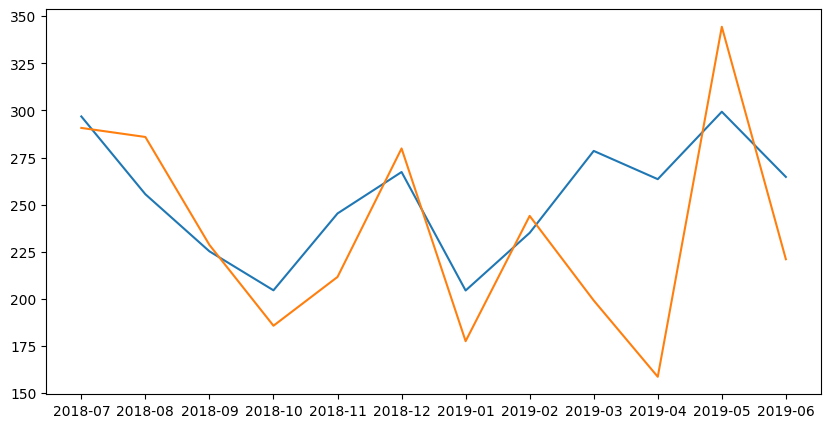

In [15]:
for store in trial_stores:
    plot_trial(store, control_stores[store], 'total_sales')


In [16]:
def recommendation(row):
    if row['Sales p-value'] < 0.05 and row['Sales Uplift %'] > 0:
        return "Roll out"
    else:
        return "Do not roll out"

results_df['Recommendation'] = results_df.apply(recommendation, axis=1)
results_df


,Trial Store,Control Store,Sales Uplift %,Sales p-value,Customer Uplift %,Txn/Customer Uplift %,Recommendation
0,77,233.0,14.90,0.3205,11.74,-1.15,Do not roll out
1,86,155.0,4.52,0.3505,8.18,-3.12,Do not roll out
2,88,125.0,30.02,0.0008,21.88,5.11,Roll out


✅ What This Notebook Covers (Quantium Checklist)

✔ Monthly metrics
✔ Control store selection using similarity
✔ Function-based approach
✔ Visual validation
✔ Statistical testing
✔ Business recommendation